# Smart Taxi

<div align="center">
    <img src="./images/taxi.gif" width="300" alt="Taxi Environment">
</div>

A taxi navigates in a grid world, pickes up a passenger and drops off at one of four locations.

## The Environment

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations. The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends. The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

**State Space/Observations:** There are 500 (25x5x4) discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. Destination on the map are represented with the first letter of the color. Passenger locations: 0 (Red), 1 (Green), 2 (Yellow), 3 (Blue), and 4 (Onboard/In taxi). Destinations: 0 (Red), 1 (Green), 2 (Yellow), 3 (Blue)

**Action Space:** 6 discrete actions.
0: Move South, 1: Move North, 2: Move East, 3: Move West, 4: Pickup passenger and 5: Drop off passenger

**Rewards:** -1 per step (default reward with time penalty), +20 for successful drop-off, -10 for illegal pickup/drop-off actions. There will be default reward for illegal moves (such as moving towards barriers) with state unchanged.

**Starting State:** There are 300 possible initial states: 25 taxi positions, 4 passenger locations (excluding inside the taxi) and 3 destinations (excluding the passenger’s current location).

**Episode Termination:** Episode terminates (1) when taxi drops off the passenger successfully or the episode is truncated (1) when length of the episode reaches 200.

In [1]:
import gymnasium as gym

# Creates the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="ansi")

# Show environment details
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

Action Space: Discrete(6)
Observation Space: Discrete(500)


In [4]:
# Resets the environment to an initial state and returns the initial observation
initial_observation, info = env.reset()
print("Initial Observation:", initial_observation)
print("Decoded Initial Observation [taxi row, taxi column, passenger location, destination]:", list(env.unwrapped.decode(initial_observation)))

Initial Observation: 386
Decoded Initial Observation [taxi row, taxi column, passenger location, destination]: [3, 4, 1, 2]


In [5]:
# Render the initial state of the environment
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Passenger and destination location are rendered as blue and magenta, respectively.

In [6]:
# Looking into the transition table to know the transition dynamics 
# with respect to the actions taken from the current state
print("\nTransition dynamics for each of the six actions from the initial state:")
env.unwrapped.P[initial_observation]


Transition dynamics for each of the six actions from the initial state:


{0: [(1.0, 486, -1, False)],
 1: [(1.0, 286, -1, False)],
 2: [(1.0, 386, -1, False)],
 3: [(1.0, 366, -1, False)],
 4: [(1.0, 386, -10, False)],
 5: [(1.0, 386, -10, False)]}

The four-variable tuble in each row represents (state-change probability, next_state, reward, epiosode over)


## Random Actions
Takes random actions, visualizes the environment after each action and measures the performance.


In [ ]:
import time
from IPython.display import clear_output
import numpy as np

# It now takes random actions, visualizes the environment after each action and measures the performance

done = False        # To track the end of the episode

env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)   # To record episode statistics

while not done:     # Loops until the episode ends
    action = env.action_space.sample()  # Samples a random action
    
    # Takes the action and returns the results
    next_state, reward, terminated, truncated, info = env.step(action) # terminated: drops-off the passenger at the correct location; truncated: max steps reached
    
    print(env.render())     # Renders the environment after taking the action
    time.sleep(0.05)        # Pauses for a second to visualize the rendering
    clear_output(wait=True) # Clears the output to update the rendering

    done = terminated or truncated  # Episode ends if terminated or truncated

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)



The rendered observation shows the the passenger was not dropped-off in destination and the episode was over either due to limit (which is 200 steps) reached or drop-off action was taken in any state other than destination state.

In [8]:
# Measuring the performance
print("Performance of random actions in one episode:\nSteps: {0}, Rewards: {1}".format(
    env.length_queue[0], env.return_queue[0]))

Performance of random actions in one episode:
Steps: 200, Rewards: -758.0


The same exercise of random actions can also be extended over multiple episodes to generalize and to show ineffectiveness of random action in this problem settings.

In [ ]:
n_eval_episodes = 5  # Number of episodes to run
eval_rewards = []
eval_episode_steps = []

env.reset()  # Resets the environment to an initial state

# Instead of auto-recording of statistics, rewards and steps are tracked manually here
#env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_eval_episodes)   

for episode in range(n_eval_episodes):
    done = False        # To track the end of the episode
    episode_rewards = 0  # To accumulate rewards in the episode
    episode_steps = 0   # To count steps in the episode

    while not done:     # Loops until the episode ends
        action = env.action_space.sample()  # Samples a random action
        
        # Takes the action and returns the results
        next_state, reward, terminated, truncated, info = env.step(action)

        episode_rewards += reward        # Accumulates the reward
        episode_steps += 1              # Increments the step count
        
        done = terminated or truncated  # Episode ends if terminated or truncated

    eval_rewards.append(episode_rewards)        # Appends the total reward of the episode
    eval_episode_steps.append(episode_steps)   # Appends the total steps of the episode
    print(f"Evaluation Episode {episode + 1}: Reward = {episode_rewards}, Steps = {episode_steps}")

    env.reset()  # Resets the environment for the next episode

print(f"\nAverage Evaluation Reward: {np.mean(eval_rewards):.2f}")
print(f"Average Evaluation Steps: {np.mean(eval_episode_steps):.2f}")


Evaluation Episode 1: Reward = -686, Steps = 200
Evaluation Episode 2: Reward = -803, Steps = 200
Evaluation Episode 3: Reward = -821, Steps = 200
Evaluation Episode 4: Reward = -920, Steps = 200
Evaluation Episode 5: Reward = -821, Steps = 200

Average Evaluation Reward: -810.20
Average Evaluation Steps: 200.00


## The Agent

Now we'll implement the Q-learning agent with methods for action selection, Q-value updates, and exploration decay. The Q-learning update rule is given by:

$Q(s,a) \leftarrow Q(s,a) + \alpha[R + \gamma \max_{a'} Q(s',a') - Q(s,a)]$

Where:
- $Q(s,a)$: Q-value for state $s$ and action $a$
- $\alpha$: Learning rate (0 to 1)
- $R$: Immediate reward
- $\gamma$: Discount factor (0 to 1)
- $s'$: Next state
- $\max_{a'} Q(s',a')$: Maximum Q-value for next state
- $[R + \gamma \max_{a'} Q(s',a') - Q(s,a)]$: Temporal-difference (TD) error



In [10]:
from collections import defaultdict

class TaxiAgent:
    """ A Q-learning agent for the Taxi-v3 environment. """
    
    def __init__(self, env, lr, initial_epsilon, epsilon_decay, final_epsilon, discount_factor):
        """
        Initializes the TaxiAgent with the given parameters.
        Args:
            env: The Taxi-v3 environment.
            lr (float): Learning rate (0 to 1).
            initial_epsilon (float): Initial exploration rate (0 to 1).
            epsilon_decay (float): Decay rate for exploration (0 to 1).
            final_epsilon (float): Minimum exploration rate (0 to 1).
            discount_factor (float): Discount factor for future rewards (0 to 1).
        """
        self.env = env
        self.lr = lr
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = discount_factor

        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))    # Initializes Q-table with zeros

        # Tracks performance metrics during training
        self.training_rewards = []  # Stores rewards per episode during training
        self.training_steps = []    # Stores steps per episode during training

    def get_action(self, state):
        """
        Selects an action using the epsilon-greedy policy.
        
        Args:
            state (int): The current state of the environment.

        Returns:
            action (int): The action selected.
        """

        if np.random.rand() < self.epsilon:         # Explores by sampling a random action
            return self.env.action_space.sample()
        elif np.sum(self.q_table[state]) == 0:      # Also explores by sampling a random action when all Q-values are zero
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])   # Exploits by selecting the action with max Q-value

    def update_q_value(self, state, action, reward, next_state, done):
        """
        Updates the Q-value for a given state-action pair using the Q-learning update rule.
        
        Args:
            state (int): The current state.
            action (int): The action taken.
            reward (float): The reward received after taking the action.
            next_state (int): The state reached after taking the action.
            done (bool): Whether the episode has ended.
        """
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + (self.discount_factor * self.q_table[next_state][best_next_action] * (not done))
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_delta

    def decay_epsilon(self):
        """Decays the exploration rate (epsilon) after each episode."""
        if self.epsilon > self.final_epsilon:
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.final_epsilon)

    def train(self, n_episodes):
        """
        Trains the agent using the Q-learning algorithm over a specified number of episodes.
        
        Args:
            n_episodes (int): The number of episodes to train the agent.
        """

        training_rewards = []  # Stores rewards per episode during training
        training_steps = []    # Stores steps per episode during training

        # Loops over specified number of episodes
        for episode in range(n_episodes):
            state, info = self.env.reset()      # Resets the environment to an initial state
            episode_reward = 0                  # To accumulate rewards in the episode
            episode_steps = 0                   # To count steps in the episode

            done = False                        # Loops until the episode ends

            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, info = self.env.step(action)

                self.update_q_value(state, action, reward, next_state, terminated or truncated)

                state = next_state
                episode_reward += reward
                episode_steps += 1

                done = terminated or truncated
            
            training_rewards.append(episode_reward)
            training_steps.append(episode_steps)

            self.decay_epsilon()

        return training_rewards, training_steps     # Returns training metrics


## Training the Agent

In [11]:
# Initializes the TaxiAgent with specified hyperparameters
agent = TaxiAgent(
    env=env,
    lr=0.1,
    initial_epsilon=1.0,
    epsilon_decay=0.9,
    final_epsilon=0.01,
    discount_factor=0.95
)

n_train_episodes = 20000                                            # Number of training episodes
training_rewards, training_steps = agent.train(n_train_episodes)    # Trains the agent over specified number of episodes
print(f"Training completed over {n_train_episodes} episodes.")

Training completed over 20000 episodes.


### Analyzing the Trained Agent

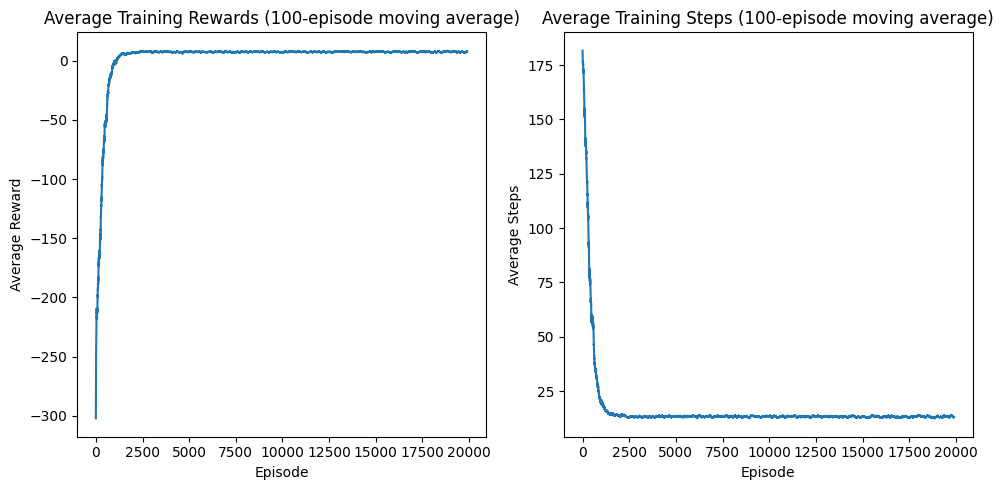

In [ ]:
# Plots the average training rewards and steps per episode
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(np.convolve(training_rewards, np.ones(100)/100, mode='valid'))
plt.title('Average Training Rewards (100-episode moving average)')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

plt.subplot(1, 2, 2)
plt.plot(np.convolve(training_steps, np.ones(100)/100, mode='valid'))
plt.title('Average Training Steps (100-episode moving average)')
plt.xlabel('Episodes')
plt.ylabel('Average Steps')

plt.tight_layout()
plt.show()


## Evaluating the Trained Agent

Let's now manually check if the Q-table has appropriate Q-values for possible actions against the specified state before analyzing the agent generally.

In [14]:
# Resets the environment and renders the initial state
initial_state, _ = env.reset()
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [15]:
# Decodes the initial state to understand current taxi location, passenger location, and destination
print("[taxi row, taxi column, passenger location, destination]:", list(env.unwrapped.decode(initial_state)))

[taxi row, taxi column, passenger location, destination]: [2, 1, 3, 1]


In [16]:
agent.q_table[initial_state]  # Displays the Q-values for the initial state

array([-4.06975889, -4.08081047,  3.94947757, -4.05874779, -5.08002407,
       -4.1587415 ])

Amongst all the Q-values, the one against the action to move to the "east" direction has the highest value justifying the correct move with respect to visual state representation in the above cell confirming appropriate training of the agent.

Now, perform the generalized analysis the agent by evaluating it over few episodes.

In [18]:
# Evaluates the trained agent over specified number of episodes

n_eval_episodes = 5         # Number of episodes to run
eval_rewards = []           # Stores rewards per episode during evaluation
eval_episode_steps = []     # Stores steps per episode during evaluation

# Loops over specified number of episodes
for episode in range(n_eval_episodes):
    done = False                            # Tracks the end of the episode
    episode_rewards = 0                      # Accumulates rewards in the episode
    episode_steps = 0                       # Counts steps in the episode

    state, _ = env.reset()                  # Resets the environment to an initial state in every episode

    # Loops until the episode ends
    while not done:
        action = agent.get_action(state)    # Selects action using the agent's policy
        
        next_state, reward, terminated, truncated, info = env.step(action)     # Takes the action and returns the results

        episode_rewards += reward            # Accumulates the reward
        episode_steps += 1                  # Increments the step count
        
        done = terminated or truncated      # Episode ends if terminated or truncated

        state = next_state                  # Updates the current state

    eval_rewards.append(episode_rewards)        # Appends the total reward of the episode
    eval_episode_steps.append(episode_steps)    # Appends the total steps of the episode
    print(f"Evaluation Episode {episode + 1}: Reward = {episode_rewards}, Steps = {episode_steps}")
    
print(f"\nAverage Evaluation Reward: {np.mean(eval_rewards):.2f}")
print(f"Average Evaluation Steps: {np.mean(eval_episode_steps):.2f}")


Evaluation Episode 1: Reward = 10, Steps = 11
Evaluation Episode 2: Reward = 7, Steps = 14
Evaluation Episode 3: Reward = 6, Steps = 15
Evaluation Episode 4: Reward = 10, Steps = 11
Evaluation Episode 5: Reward = 6, Steps = 15

Average Evaluation Reward: 7.80
Average Evaluation Steps: 13.20


The above performance of the agent over 5-episode evaluation is much higher than the performance of random actions recorded in the beginning of this notebook.

In [19]:
env.close()     # Closes the environment to release resources